In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model

Updated brackish water LCOW calculations

In [89]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs.csv')
netl_df = pd.read_csv("/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Power/NETL_ThermalPlants_Filtered.csv")

Updating powerplant dataframe to group demand with the same plant code (independent of fuel)\
Filter powerplants where freshwater is used and where all the data is available --> this filter is copied from previous files

In [90]:
pp_df = netl_df[((netl_df.WaterType == 'Fresh') & (netl_df.WAvg != '...') & (netl_df.WAvg != '---'))]
pp_group= pp_df.groupby('PlantCode')
pp_df.WAvg = pp_df.WAvg.astype(float)
cols= ['PlantCode','Demand_m3/s','PPLatitude','PPLongitude']

pp_combined_df = pd.DataFrame(columns = cols)
pp_group= pp_df.groupby('PlantCode')

for key in pp_group.groups.keys():

    demand = sum((pp_group.get_group(key).WAvg * 0.0037854 / 3600) * pp_group.get_group(key).Capacity)
    # pp_combined_df = pp_combined_df.append
    temp_dict = {'PlantCode':key,
                 'PlantState':pp_group.get_group(key)['PlantState'].values[0],
                 'Demand_m3/s': demand ,
                 'PPLatitude':pp_group.get_group(key)['Latitude'].values[0],
                 'PPLongitude':pp_group.get_group(key)['Longitude'].values[0]}
    
    temp = pd.DataFrame(temp_dict,index= [0])                  
    pp_combined_df = pd.concat([pp_combined_df,temp],ignore_index=True)
    pp_combined_df.reset_index()


In [21]:
pp_combined_df[pp_combined_df['PlantState']== 'AZ']

,PlantCode,Demand_m3/s,PPLatitude,PPLongitude,PlantState
10,113,0.536009,34.93940,-110.303,AZ
11,117,0.173992,33.44170,-112.158,AZ
12,126,0.176372,32.16000,-110.905,AZ
257,6177,0.471277,34.57890,-109.271,AZ
313,8068,0.242019,33.33250,-111.750,AZ
318,8223,0.866628,34.31860,-109.164,AZ
333,55124,0.161374,35.05403,-114.133,AZ
334,55129,0.163882,32.90420,-111.789,AZ
342,55177,0.157032,34.86780,-114.532,AZ
360,55282,0.172507,33.34170,-112.890,AZ


State wise boxplots
1. Group state wise
2. Create function for analysis done in Texas

In [120]:
# State wise operation functions

def state_pp_calc(state_code):
    
    # Get state sub-dataframe
    bw_state_df = bw_df[bw_df['state_alpha']==state_code]
    bw_state_df = bw_state_df.set_index('unique_site_ID')

    pp_state_df =  pp_combined_df[pp_combined_df['PlantState']==state_code]
    pp_state_df = pp_state_df.set_index('PlantCode')

    cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

    one_pp_many_bw_df  = pd.DataFrame(columns=cols)

    for pp in pp_state_df.index:
        pp_long = pp_state_df['PPLongitude'].loc[pp]
        pp_lat = pp_state_df['PPLatitude'].loc[pp]

        pp_loc = (pp_lat,pp_long)    

        plantcode = pp
        
        for site in bw_state_df.index:
            bw_long = bw_state_df['Longitude'].loc[site]
            bw_lat = bw_state_df['Latitude'].loc[site]

            bw_loc = (bw_lat,bw_long)
            dist_km = hs.haversine(pp_loc,bw_loc)
            
            bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
            pp_demand_frac_met = bw_available/pp_state_df['Demand_m3/s'].loc[pp]
            lcow = bw_state_df['lcow'].loc[site]

            # Updated transport costs
            
            transport_lcow_pipe = pipe_costing(bw_available*3600*24,dist_km*1.6)
            transport_lcow_truck = truck_costing(dist_km*1.6)

            transport_lcow = min(transport_lcow_pipe,transport_lcow_truck)
            tlcow = lcow + transport_lcow

            temp_dict ={'State' : state_code,
                        'PlantCode' : plantcode,
                        'PPLatitude' : pp_lat,
                        'PPLongitude' : pp_long,
                        'PPDemand' : pp_state_df['Demand_m3/s'].loc[pp],
                        'BWSites' : site,
                        'BWLatitude' : bw_lat,
                        'BWLongitude' : bw_long,
                        'BWAvailable' : bw_available,
                        'Distance_km' : dist_km,
                        'PPDemandFracMet' : pp_demand_frac_met,
                        'LCOW' : lcow,
                        'TransportLCOW' : transport_lcow,
                        'tLCOW' : tlcow,
                        'WeightedtLCOW': 0,
                        'Cum_PPDemandFracMet': 0}
            
            temp = pd.DataFrame(temp_dict,index= [0])    
            one_pp_many_bw_df = pd.concat([one_pp_many_bw_df,temp],ignore_index=True)
            one_pp_many_bw_df.reset_index()

    weighted_lcow = []
    cum_pp_demand_frac_met = []

    one_pp_many_bw_df_sorted1 = one_pp_many_bw_df.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
    one_pp_many_bw_df = one_pp_many_bw_df_sorted1.apply(pd.DataFrame).set_index('PlantCode')

    for pp in pp_state_df.index:
        cum_bw_available = np.array(one_pp_many_bw_df['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((one_pp_many_bw_df['BWAvailable'].loc[pp]*one_pp_many_bw_df['tLCOW'].loc[pp]).cumsum())
        temp = np.divide(cum_cost,cum_bw_available)
        weighted_lcow = np.append(weighted_lcow, temp,axis=0)
        temp_demand_met = np.array(one_pp_many_bw_df['PPDemandFracMet'].loc[pp].cumsum())
        cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

    one_pp_many_bw_df['WeightedtLCOW'] = weighted_lcow
    one_pp_many_bw_df['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
            
    return (one_pp_many_bw_df)


In [175]:
cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

one_pp_many_bw_all_states_df  = pd.DataFrame(columns=cols)

state_codes = ['AL','AZ','AR','CA','CO','CT','FL','GA','ID','IL','IN','IA','KS','KY','LA','MD','MA','MI','MN','MS','MO','MT','NE',
                  'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','SC','SD','TN','TX','UT','VA','WA','WV','WI','WY']

for state in state_codes:
    sample = state_pp_calc(state)
    one_pp_many_bw_all_states_df = pd.concat([one_pp_many_bw_all_states_df,sample])


In [176]:
one_pp_many_bw_all_states_df.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Source to Use Scenarios/Brackish to Power/one_pp_many_bw_all_states_df.csv')

In [3]:
one_pp_many_bw_all_states_df_read = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Source to Use Scenarios/Brackish to Power/one_pp_many_bw_all_states_df.csv').set_index('Unnamed: 0')
one_pp_many_bw_all_states_df_read.index.names = ['PlantCode']
one_pp_many_bw_all_states_df_read = one_pp_many_bw_all_states_df_read.drop('PlantCode',axis=1)

Box Plots

In [47]:
one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[(one_pp_many_bw_all_states_df_read['Cum_PPDemandFracMet']<=100)].groupby('PlantCode').last()
# one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read.groupby('PlantCode').last()

Text(0.5, 0.98, ' ')

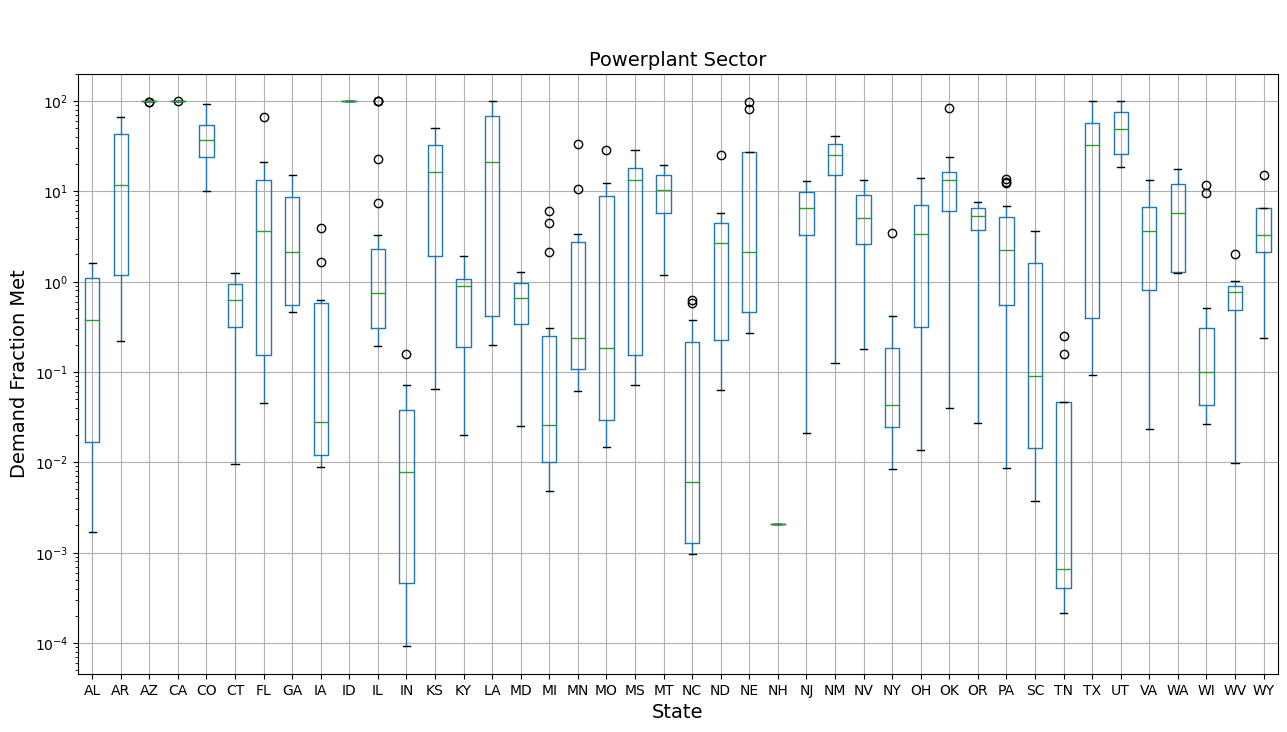

In [48]:
ax = one_pp_many_bw_all_states_df_plot.boxplot('Cum_PPDemandFracMet',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('Demand Fraction Met',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
# ax.set_ylim([0,100])
plt.yscale('log')
plt.suptitle(' ')

Text(0.5, 0.98, ' ')

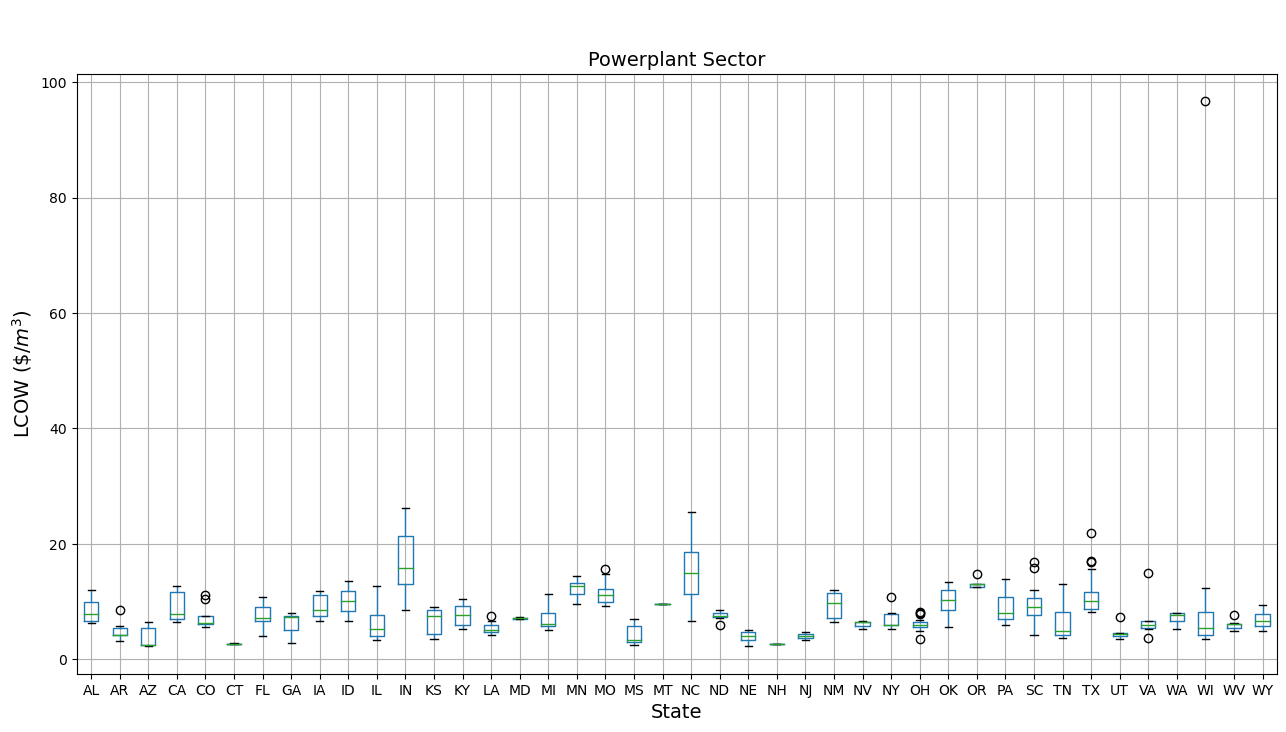

In [38]:
ax= one_pp_many_bw_all_states_df_plot.boxplot('WeightedtLCOW',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
# ax.set_ylim([0,1.6])
plt.suptitle(' ')

In [43]:
max_LCOW = 1.6
one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[(one_pp_many_bw_all_states_df_read['Cum_PPDemandFracMet']<=1) 
                                        & (one_pp_many_bw_all_states_df_read['WeightedtLCOW']<=max_LCOW)].groupby('PlantCode').last()

# one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[ (one_pp_many_bw_all_states_df_read['WeightedtLCOW']<=max_LCOW)].groupby('PlantCode').last()

In [44]:
one_pp_many_bw_all_states_df_plot

,State,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet
PlantCode,,,,,,,,,,,,,,,
10,AL,32.60170,-87.7811,32.119974,USGS-323012087492701,32.503471,-87.824181,0.032961,11.644975,0.001026,0.954613,0.510686,1.465299,1.465299,0.001026
51,LA,32.03056,-93.5692,0.433224,USGS-322052093374701,32.347935,-93.629898,0.044608,35.749762,0.102967,0.819837,1.160315,1.980152,1.562555,0.303102
87,NM,35.41590,-108.0820,0.126887,FETH-351645N1075900.1,35.279167,-107.983361,0.087078,17.640843,0.686266,0.763707,0.446507,1.210214,1.210214,0.686266
113,AZ,34.93940,-110.3030,0.536009,USGS-345306110170801,34.885025,-110.286232,0.043902,6.236558,0.081905,0.889411,0.284448,1.173858,0.972838,0.951541
126,AZ,32.16000,-110.9050,0.176372,USGS-321129110593401,32.190632,-110.992867,0.071813,8.943801,0.407167,0.752811,0.290384,1.043196,1.029606,0.869516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59326,OH,39.46500,-84.3478,0.100572,USGS-393853084170700,39.648113,-84.285217,0.093691,21.056319,0.931577,0.725425,0.499544,1.224969,1.224969,0.931577
59338,AZ,32.97500,-112.6940,0.148293,USGS-325820112420201,32.972267,-112.701279,0.139695,0.743882,0.942017,0.765505,0.086037,0.851542,0.851542,0.942017
59784,AZ,32.97500,-112.6940,0.142832,USGS-325820112420201,32.972267,-112.701279,0.139695,0.743882,0.978034,0.765505,0.086037,0.851542,0.851542,0.978034


Text(0.5, 0.98, ' ')

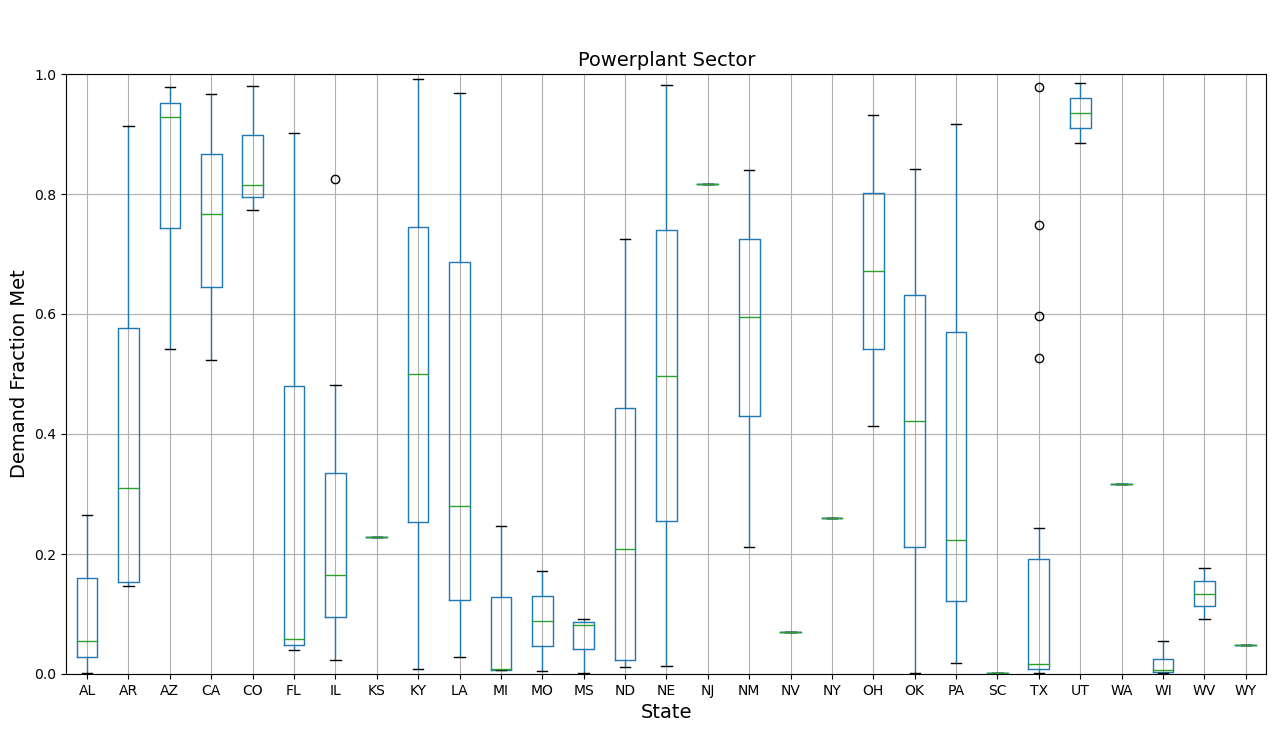

In [45]:
ax = one_pp_many_bw_all_states_df_plot.boxplot('Cum_PPDemandFracMet',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('Demand Fraction Met',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
ax.set_ylim([0,1])
# plt.yscale('log')
plt.suptitle(' ')

Text(0.5, 0.98, ' ')

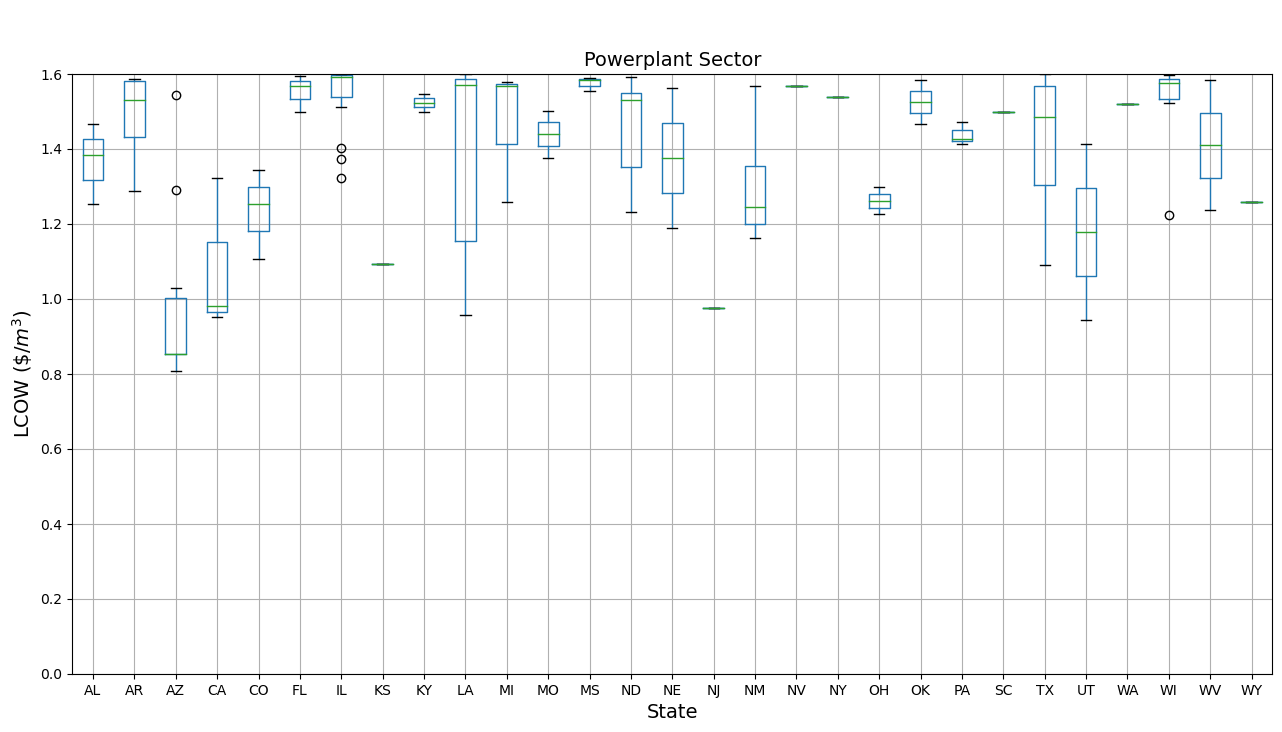

In [46]:
ax= one_pp_many_bw_all_states_df_plot.boxplot('WeightedtLCOW',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
ax.set_ylim([0,1.6])
plt.suptitle(' ')